In [1]:
# 주식 종목 불러오는 패키지
!pip install finance-datareader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 1.6 MB/s eta 0:00:00


In [2]:
#FinanceDataReader : 한국, 미국, 전 세계 주식 데이터를 가져오는 라이브러리

import FinanceDataReader as fdr

# 삼성전자

In [3]:
# 삼성전자로 세팅됨, 종목번호 및 기간 바꿔서 진행
df = fdr.DataReader('005930', '2024-01-01', '2025-12-31') #005930 : 삼성전자 종목코드
df.tail()

#Volume : 거래량. 그날 거래된 주식 수 (얼마나 활발히 거래됐는지 보여줌)
#Change : 변동률. 전날 종가 대비 몇 퍼센트 오르거나 내렸는지

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2025-07-17,65900,66800,64400,66700,39448683,0.030912
2025-07-18,67000,67800,66300,67100,23951531,0.005997
2025-07-21,67400,68800,67200,67800,17723148,0.010432
2025-07-22,68100,68500,65600,66000,20829006,-0.026549
2025-07-23,66200,66500,64900,66000,11233721,0.000000


# 분석 코드

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim

In [5]:
# GPU 꼭 연결해서 사용하세요~! (GPU 먼저, 안되면 CPU 사용)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

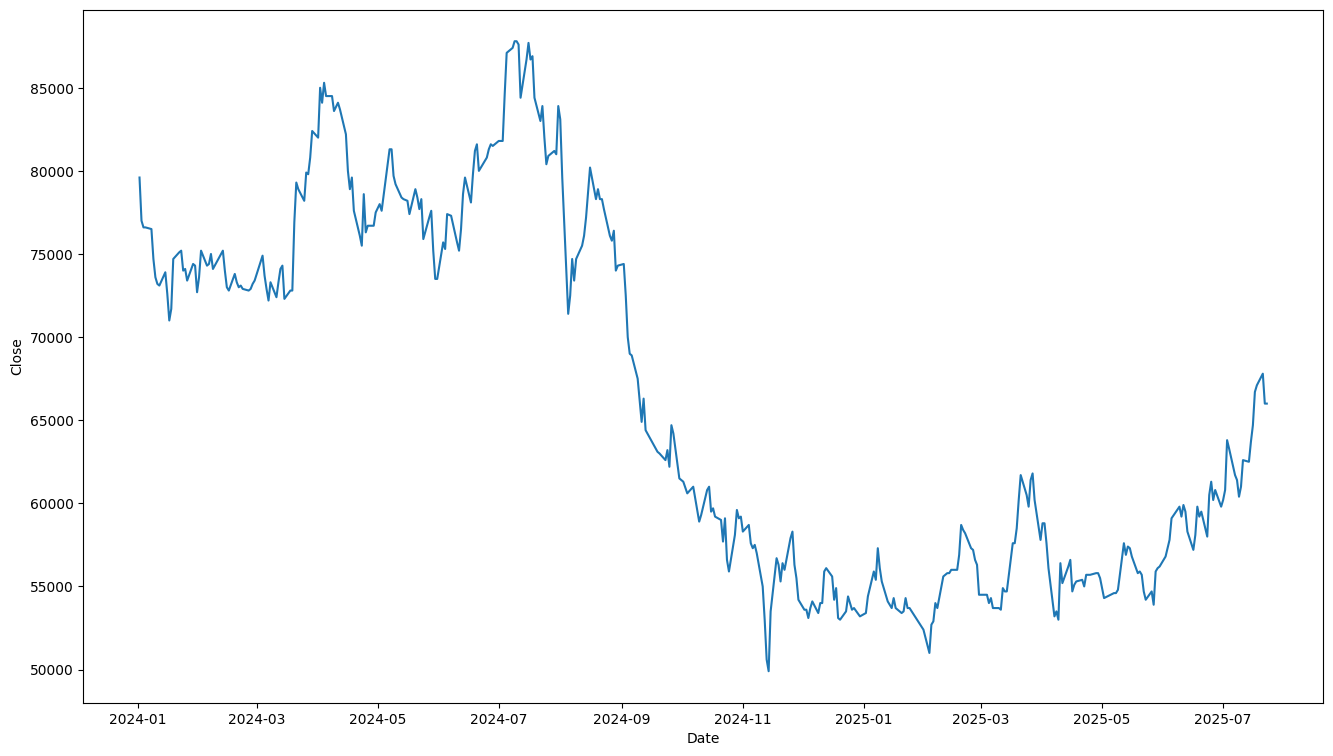

In [6]:
plt.figure(figsize=(16, 9))
sns.lineplot(x=df.index, y='Close', data=df) #종가 시계열그래프
plt.show()

# 데이터 전처리

In [21]:
#종가 제외 스케일링 (반응변수 = 종가) -> 정답이니까 그대로 두고 나머지 스케일링
scaler = MinMaxScaler()
df[['Open', 'High', 'Low', 'Volume']] = scaler.fit_transform(df[['Open','High', 'Low','Volume']])

#Close도 스케일링 필요
df['Close'] = scaler.fit_transform(df[['Close']]) # 'Close' 컬럼 스케일링

In [22]:
#넘파이 배열로 변경 (딥러닝 학습을 위해)
x = df[['Open', 'High', 'Low', 'Volume']].values
y = df['Close'].values

#시퀀스(연속된 데이터 묶음) 데이터 생성하는 함수

#x : 2차원 넘파이 배열 (Open, High, Low, Volume)
#y : 종가(Close) 값들이 들어있는 배열
#sequence_length: 몇 일치 데이터를 한 덩어리로 묶을지 설정 (ex) 5일)

def seq_data(x, y, sequence_length):
  x_seq = []
  y_seq = []
  for i in range(len(x) - sequence_length): #전체 데이터 길이에서 시퀀스 길이만큼 뺀 범위까지 반복 ex) 300일 데이터면 마지막 시점은 295번째까지 가능
    x_seq.append(x[ i : i + sequence_length]) #5일치 데이터 -> 하나의 시퀀스로 저장 ex) 1-5일 데이터
    y_seq.append(y[i + sequence_length]) #5일 이후 다음날 종가 -> 정답 ex) 6일 종가

  #gpu용 텐서로 변환
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)

In [23]:
#과거 데이터를 기반으로 미래 예측을 하기 때문에 데이터를 시간 순으로 나눠야함

split = 200
sequence_length=5 # 5일치씩 묶기
x_seq, y_seq = seq_data(x, y, sequence_length) #ex) x_seq.shape = [250,5,4]

#전체시퀀스에서 앞에 있는 x,y 200개는 학습용 데이터
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]

#나머지는 테스트용 데이터
x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]

# 학습용 200개 / 테스트용 174 개
print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

torch.Size([200, 5, 4]) torch.Size([200, 1])
torch.Size([174, 5, 4]) torch.Size([174, 1])


In [24]:
x_train_seq #torch.Size([200, 5, 4])

tensor([[[0.7311, 0.7594, 0.7608, 0.2179],
         [0.7389, 0.7326, 0.7285, 0.3068],
         [0.6762, 0.6925, 0.7043, 0.1828],
         [0.6919, 0.6872, 0.7124, 0.1052],
         [0.6997, 0.6979, 0.7124, 0.1011]],

        [[0.7389, 0.7326, 0.7285, 0.3068],
         [0.6762, 0.6925, 0.7043, 0.1828],
         [0.6919, 0.6872, 0.7124, 0.1052],
         [0.6997, 0.6979, 0.7124, 0.1011],
         [0.7102, 0.7032, 0.6559, 0.3891]],

        [[0.6762, 0.6925, 0.7043, 0.1828],
         [0.6919, 0.6872, 0.7124, 0.1052],
         [0.6997, 0.6979, 0.7124, 0.1011],
         [0.7102, 0.7032, 0.6559, 0.3891],
         [0.6475, 0.6364, 0.6263, 0.2780]],

        ...,

        [[0.2089, 0.1898, 0.1801, 0.4948],
         [0.1514, 0.1471, 0.1586, 0.3854],
         [0.1436, 0.1898, 0.1559, 0.4229],
         [0.2037, 0.2193, 0.1989, 0.4344],
         [0.2324, 0.2246, 0.2339, 0.2699]],

        [[0.1514, 0.1471, 0.1586, 0.3854],
         [0.1436, 0.1898, 0.1559, 0.4229],
         [0.2037, 0.2193, 0.1989

In [25]:
#TensorDataset : x,y를 묶어서 한덩어리로 만들어줌
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 5

#DataLoader : 데이터셋을 모델 학습에 적합한 형태로 “자동으로 잘게 나눠서” 공급해주는 도구 (week1 복습과제1 )
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size = batch_size, shuffle=True) #학습데이터 섞기(테스트용 적용 금지)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size = batch_size)

# Vanila RNN
## 모델 구축

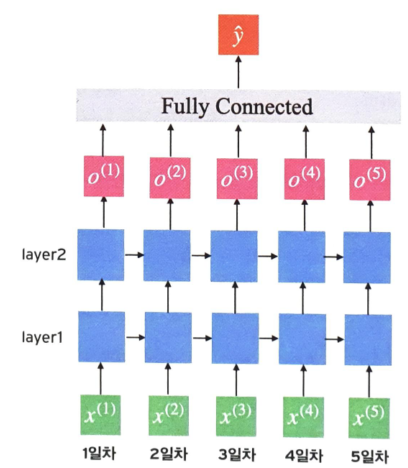

In [26]:
#기본 하이퍼 파라미터 설정
input_size = x_seq.size(2) # 하루 데이터의 feature 개수 (Open, High, Low, Volume) = 4개
num_layers = 2
hidden_size = 8 #RNN 셀 내 hidden state의 차원

In [27]:
#Vanila RNN 모델 정의

class VanillaRNN(nn.Module):

  #모델 구조 관련 정보 받아 초기설정
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(VanillaRNN, self).__init__() #nn.Module 초기화 코드
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers

    #한 줄로 모델 정의
    #batch_first = True : 입력 텐서 형태를 [batch, sequence, feature]로 사용
    #x_train_seq 같은 데이터는 이 순서로 되어 있으니까 이렇게 설정
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)

    #fully connected layer 정의 (RNN 층에서 나온 결과를 fc 층으로 전달 -> 예측값 계산)
    #RNN의 출력을 flatten -> linear layer로 넣음
    #Sigmoid 함수로 activation function 정의 (정규화된 종가 예측을 위해?? 왜??)

    self.fc = nn.Sequential(nn.Linear(hidden_size * sequence_length, 1),
                            nn.Sigmoid())


  #실제 forward propagation 과정 함수
  def forward(self, x):

    #h0 : RNN의 hidden state 초기값 (처음에는 전부 0으로 시작)
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) #초기값 0으로 설정

    #	x: [batch_size, 5, 4], out : [batch_size, 5, 8]
    out,_ = self.rnn(x, h0) #1. RNN 에 입력시퀀스 x랑 초기 hidden state 전달
    out = out.reshape(out.shape[0], -1) #2. 출력을 Flatten -> 2차원으로 . [32, 5×8] = [32, 40] 으로 펼쳐짐
    out = self.fc(out) #3. fully connected 층에 넣기 -> 예측값
    return out

In [28]:
#위에서 정의한 VanillaRNN 클래스 -> 실제 모델 객체
model = VanillaRNN(input_size=input_size,
                   hidden_size = hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers,
                   device=device).to(device) #GPU에 올림

In [29]:
criterion = nn.MSELoss() #criterion : Mean Squared Error 손실함수 (회귀문제)
num_epochs = 50
optimizer = optim.Adam(model.parameters(), lr=1e-3) #Adam optimizer 사용. learning rate = 0.001

## 모델 학습

In [30]:
loss_graph = []
n = len(train_loader) #n : 학습데이터의 mini batch 개수

for epoch in range(num_epochs): # 에폭만큼 반복
  running_loss = 0  #running_loss : 누적 손실값

  for data in train_loader:
    seq, target = data #배치 데이터에서 시퀀스랑 정답 꺼내기
    out = model(seq) #시퀀스를 모델에 넣어 출력값 계산
    loss = criterion(out, target) #손실함수 계산

    optimizer.zero_grad() #gradient 초기화
    loss.backward() #backpropagation
    optimizer.step() #최적화 -> weight 업데이트
    running_loss += loss.item()

  loss_graph.append(running_loss/n) #loss_graph : epoch 당 평균 손실 기록
  if epoch % 10 ==0:
    print('[epoch : %d] loss: %.4f' %(epoch, running_loss/n))

[epoch : 0] loss: 0.0468
[epoch : 10] loss: 0.0053
[epoch : 20] loss: 0.0044
[epoch : 30] loss: 0.0041
[epoch : 40] loss: 0.0036


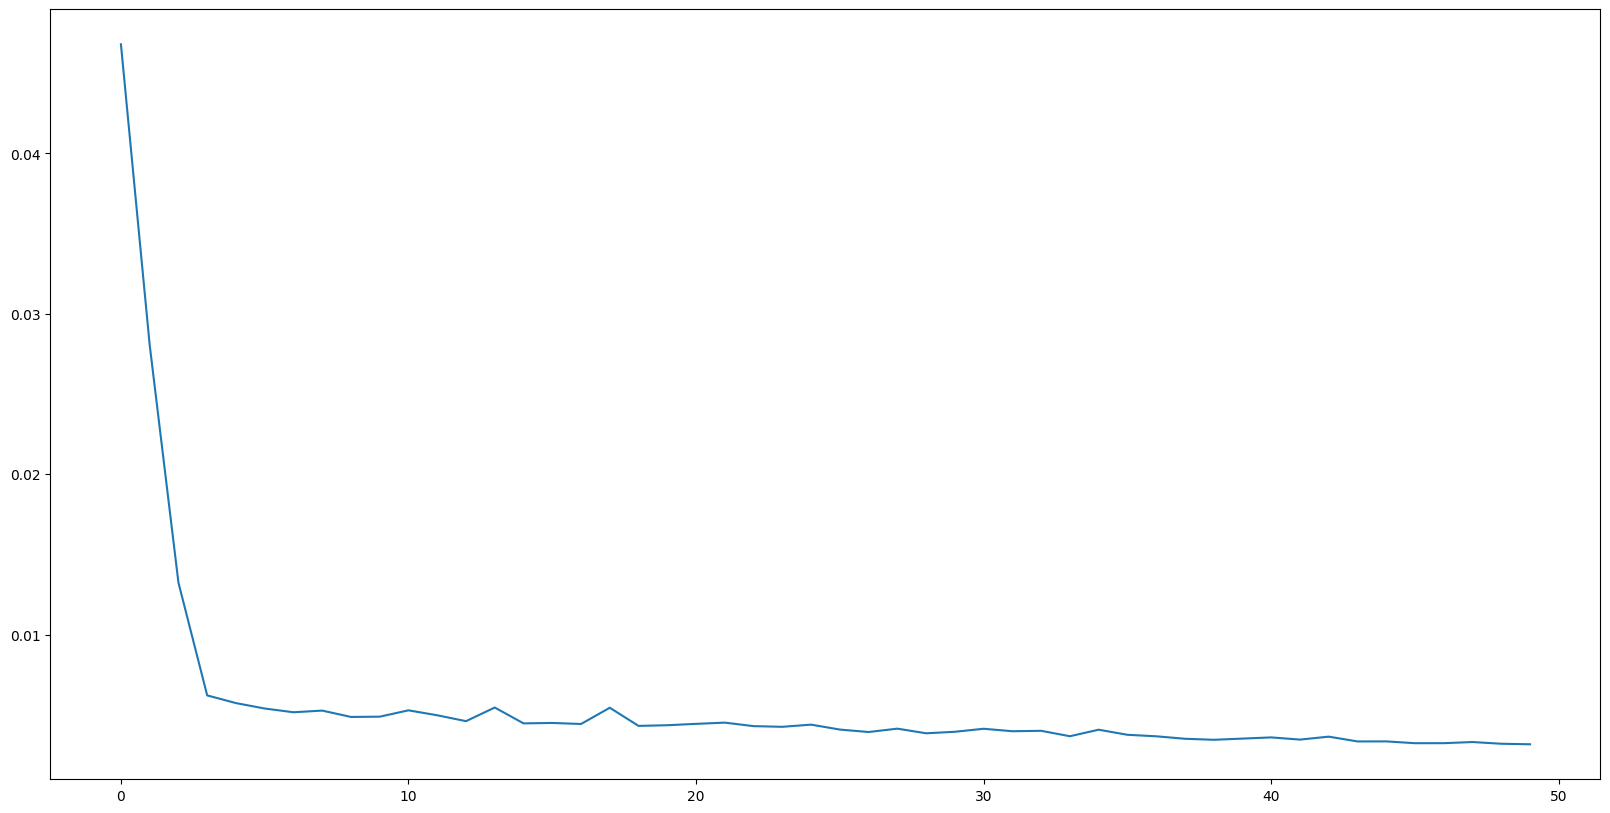

In [31]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()

## 실제값과 예측값 비교

In [32]:
concatdata = torch.utils.data.ConcatDataset([train, test]) #전체 데이터를 예측해보자
data_loader = torch.utils.data.DataLoader(dataset = concatdata, batch_size = 100) #데이터 불러오기

with torch.no_grad(): #예측할때 Gradient 계산 비활성화
  pred = []
  model.eval() #평가모드
  for data in data_loader:
    seq, target = data
    out = model(seq)
    pred += out.cpu().tolist() #pred에 예측값 계속 이어붙이기
    #GPU -> CPU -> list

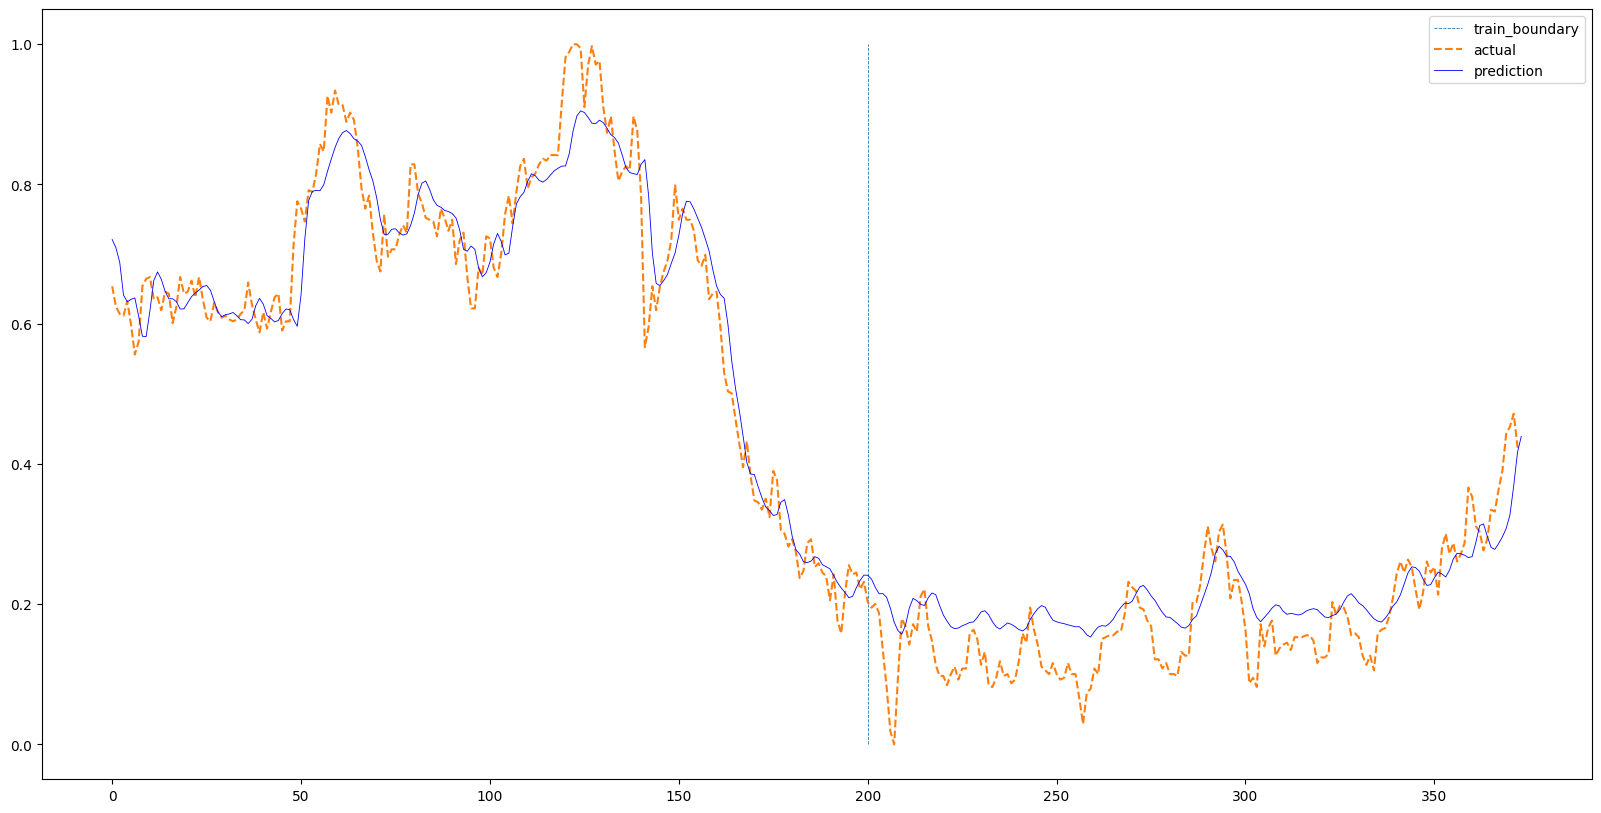

In [33]:
plt.figure(figsize = (20,10))
plt.plot(np.ones(100)*len(train), np.linspace(0,1,100), '--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred, 'b', linewidth = 0.6)
plt.legend(['train_boundary','actual','prediction'])
plt.show()

# LSTM
## 모델구축

In [34]:
#하이퍼 파라미터 정의
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [35]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(LSTM, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    #내부적으로는 forget gate, input gate, output gate가 자동으로 작동. 입력형태는 RNN과 동일
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_size*sequence_length ,1)

  def forward(self, x):
    #이번엔 hidden state 뿐 아니라 cell state(장기기억용 셀 상태)까지 초기화 -> 0으로 설정
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    c0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    out, _ = self.lstm(x,(h0,c0)) #두개의 초기상태를 받음
    out = out.reshape(out.shape[0], -1) # 모든 hidden state를 이어붙임
    out = self.fc(out)
    return out

In [36]:
#아래는 RNN 부분과 같음
model = LSTM(input_size = input_size,
             hidden_size=hidden_size,
             sequence_length=sequence_length,
             num_layers = num_layers,
             device=device).to(device)

In [37]:
criterion = nn.MSELoss()
num_epochs =50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [38]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0

    for data in train_loader:

        seq, target = data # 배치 데이터
        out = model(seq)
        loss = criterion(out, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_graph.append(running_loss/n)
    if epoch % 10 == 0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))


[epoch: 0] loss: 0.4463
[epoch: 10] loss: 0.0047
[epoch: 20] loss: 0.0043
[epoch: 30] loss: 0.0047
[epoch: 40] loss: 0.0039


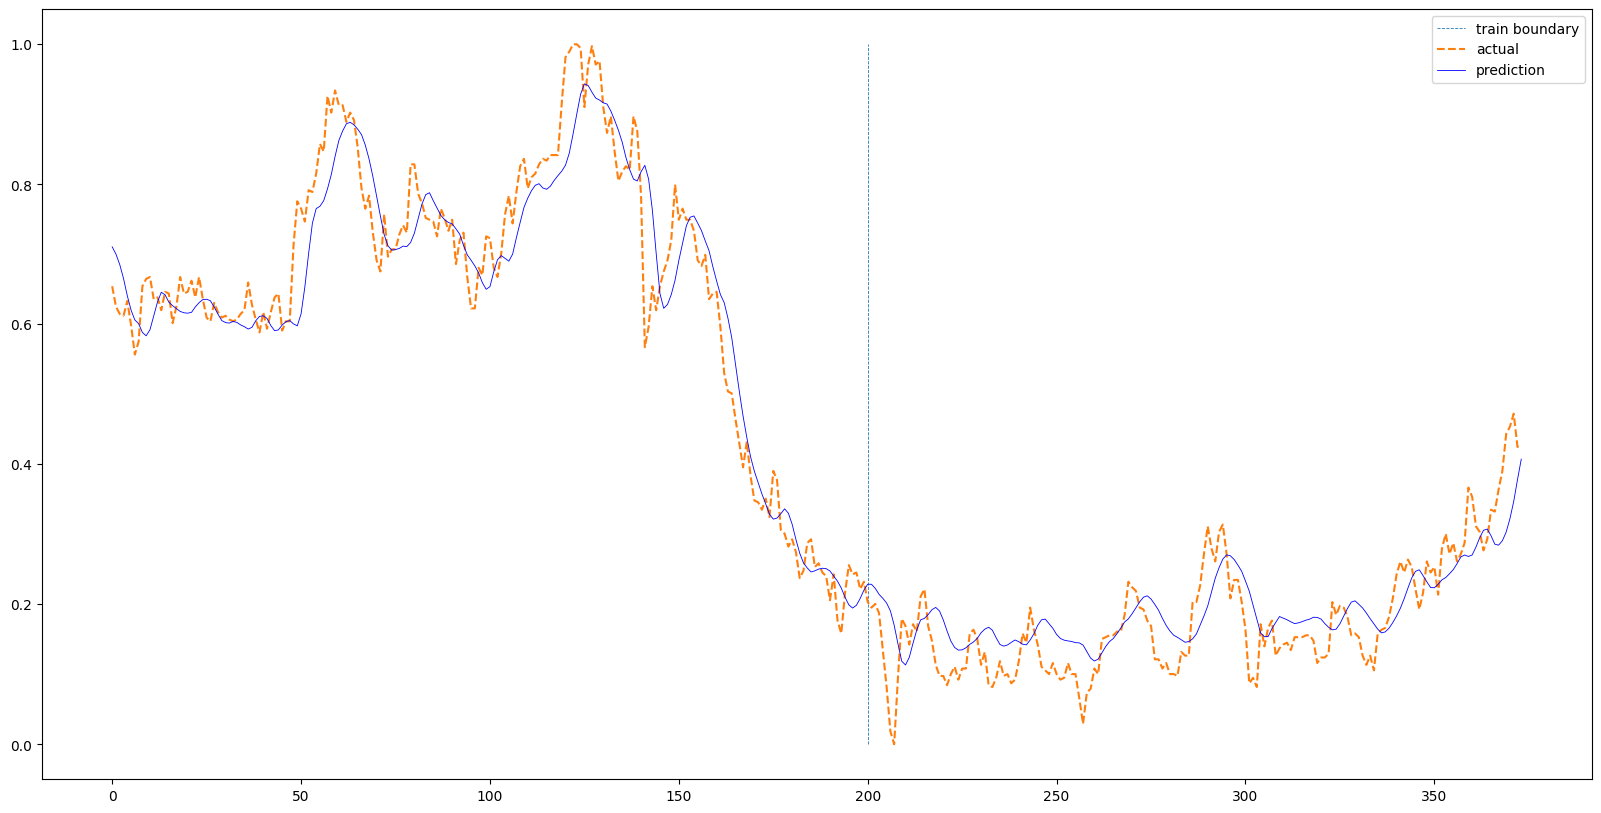

In [39]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset=concatdata, batch_size=100, shuffle=False)

with torch.no_grad():
    pred = []
    model.eval()
    for data in data_loader:
        seq, target = data
        out = model(seq)
        pred += out.cpu().tolist()

plt.figure(figsize=(20,10))
plt.plot(np.ones(100)*len(train),np.linspace(0,1,100),'--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred,'b', linewidth=0.6)
plt.legend(['train boundary','actual','prediction'])
plt.show()

# (Optional)

현대 자동차 주가에 대한 정보에 같은 분석을 해봅시다. 다음 코드를 한 번 실행한 뒤, 분석 코드부터 다시 그대로 돌려보시기 보고 결과에 대해 자유롭게 해석해보시기 바랍니다.

In [40]:
# 현대자동자 주가로 세팅됨, 종목번호 및 기간 바꿔서 진행
df = fdr.DataReader('005380', '2024-01-01', '2025-12-31')
df.tail

<bound method NDFrame.tail of               Open    High     Low   Close   Volume    Change
Date                                                         
2024-01-02  202000  202500  199800  200500   373050 -0.014742
2024-01-03  199100  199500  193800  193800   548675 -0.033416
2024-01-04  192000  192800  189100  190000   505979 -0.019608
2024-01-05  190100  190500  187200  187300   440219 -0.014211
2024-01-08  187600  188900  185500  185700   323498 -0.008542
...            ...     ...     ...     ...      ...       ...
2025-07-17  208500  212000  205500  210000   611349  0.012048
2025-07-18  210000  212500  208500  210500   317353  0.002381
2025-07-21  209500  210500  208000  209000   460835 -0.007126
2025-07-22  209000  209500  204500  206500   441603 -0.011962
2025-07-23  213000  223000  213000  222000  2309684  0.075061

[379 rows x 6 columns]>

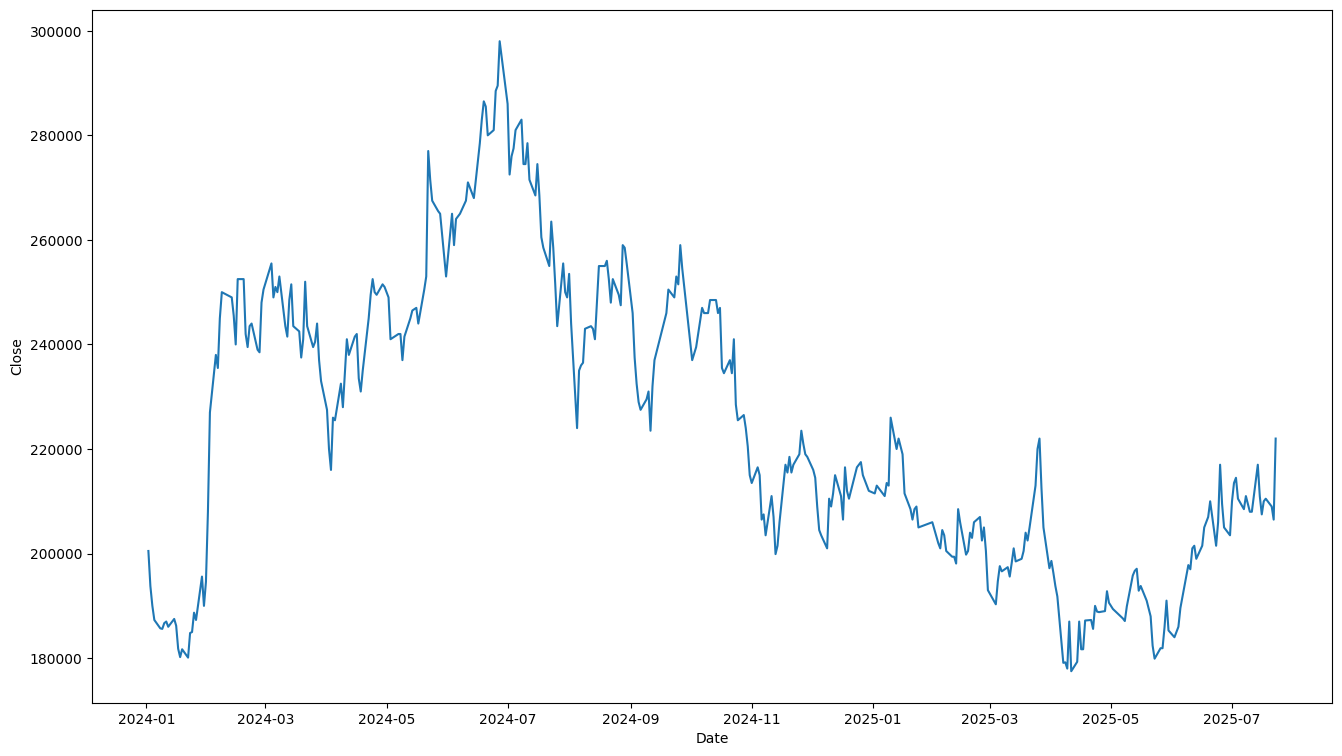

In [42]:
plt.figure(figsize=(16, 9))
sns.lineplot(x=df.index, y='Close', data=df) #종가 시계열그래프
plt.show()

In [44]:
#종가 제외 스케일링 (반응변수 = 종가) -> 정답이니까 그대로 두고 나머지 스케일링
scaler = MinMaxScaler()
df[['Open', 'High', 'Low', 'Volume']] = scaler.fit_transform(df[['Open','High', 'Low','Volume']])

#Close도 스케일링 필요
df['Close'] = scaler.fit_transform(df[['Close']]) # 'Close' 컬럼 스케일링

In [45]:
#넘파이 배열로 변경 (딥러닝 학습을 위해)
x = df[['Open', 'High', 'Low', 'Volume']].values
y = df['Close'].values

#시퀀스(연속된 데이터 묶음) 데이터 생성하는 함수

#x : 2차원 넘파이 배열 (Open, High, Low, Volume)
#y : 종가(Close) 값들이 들어있는 배열
#sequence_length: 몇 일치 데이터를 한 덩어리로 묶을지 설정 (ex) 5일)

def seq_data(x, y, sequence_length):
  x_seq = []
  y_seq = []
  for i in range(len(x) - sequence_length): #전체 데이터 길이에서 시퀀스 길이만큼 뺀 범위까지 반복 ex) 300일 데이터면 마지막 시점은 295번째까지 가능
    x_seq.append(x[ i : i + sequence_length]) #5일치 데이터 -> 하나의 시퀀스로 저장 ex) 1-5일 데이터
    y_seq.append(y[i + sequence_length]) #5일 이후 다음날 종가 -> 정답 ex) 6일 종가

  #gpu용 텐서로 변환
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)

In [46]:
#과거 데이터를 기반으로 미래 예측을 하기 때문에 데이터를 시간 순으로 나눠야함

split = 200
sequence_length=5 # 5일치씩 묶기
x_seq, y_seq = seq_data(x, y, sequence_length) #ex) x_seq.shape = [250,5,4]

#전체시퀀스에서 앞에 있는 x,y 200개는 학습용 데이터
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]

#나머지는 테스트용 데이터
x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]

# 학습용 200개 / 테스트용 174 개
print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

torch.Size([200, 5, 4]) torch.Size([200, 1])
torch.Size([174, 5, 4]) torch.Size([174, 1])


In [47]:
x_train_seq #torch.Size([200, 5, 4])

tensor([[[0.2008, 0.1862, 0.2048, 0.0262],
         [0.1770, 0.1611, 0.1536, 0.0575],
         [0.1189, 0.1049, 0.1135, 0.0499],
         [0.1033, 0.0856, 0.0973, 0.0382],
         [0.0828, 0.0721, 0.0828, 0.0174]],

        [[0.1770, 0.1611, 0.1536, 0.0575],
         [0.1189, 0.1049, 0.1135, 0.0499],
         [0.1033, 0.0856, 0.0973, 0.0382],
         [0.0828, 0.0721, 0.0828, 0.0174],
         [0.0844, 0.0629, 0.0828, 0.0219]],

        [[0.1189, 0.1049, 0.1135, 0.0499],
         [0.1033, 0.0856, 0.0973, 0.0382],
         [0.0828, 0.0721, 0.0828, 0.0174],
         [0.0844, 0.0629, 0.0828, 0.0219],
         [0.0664, 0.0587, 0.0802, 0.0187]],

        ...,

        [[0.5205, 0.5092, 0.4454, 0.1751],
         [0.4016, 0.4253, 0.3814, 0.1586],
         [0.3975, 0.4086, 0.4113, 0.0736],
         [0.3975, 0.3876, 0.3857, 0.0926],
         [0.3730, 0.3750, 0.3814, 0.0585]],

        [[0.4016, 0.4253, 0.3814, 0.1586],
         [0.3975, 0.4086, 0.4113, 0.0736],
         [0.3975, 0.3876, 0.3857

In [48]:
#TensorDataset : x,y를 묶어서 한덩어리로 만들어줌
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 5

#DataLoader : 데이터셋을 모델 학습에 적합한 형태로 “자동으로 잘게 나눠서” 공급해주는 도구 (week1 복습과제1 )
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size = batch_size, shuffle=True) #학습데이터 섞기(테스트용 적용 금지)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size = batch_size)

In [49]:
#기본 하이퍼 파라미터 설정
input_size = x_seq.size(2) # 하루 데이터의 feature 개수 (Open, High, Low, Volume) = 4개
num_layers = 2
hidden_size = 8 #RNN 셀 내 hidden state의 차원

# vanila rnn

In [50]:
#Vanila RNN 모델 정의

class VanillaRNN(nn.Module):

  #모델 구조 관련 정보 받아 초기설정
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(VanillaRNN, self).__init__() #nn.Module 초기화 코드
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers

    #한 줄로 모델 정의
    #batch_first = True : 입력 텐서 형태를 [batch, sequence, feature]로 사용
    #x_train_seq 같은 데이터는 이 순서로 되어 있으니까 이렇게 설정
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)

    #fully connected layer 정의 (RNN 층에서 나온 결과를 fc 층으로 전달 -> 예측값 계산)
    #RNN의 출력을 flatten -> linear layer로 넣음
    #Sigmoid 함수로 activation function 정의 (정규화된 종가 예측을 위해?? 왜??)

    self.fc = nn.Sequential(nn.Linear(hidden_size * sequence_length, 1),
                            nn.Sigmoid())


  #실제 forward propagation 과정 함수
  def forward(self, x):

    #h0 : RNN의 hidden state 초기값 (처음에는 전부 0으로 시작)
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) #초기값 0으로 설정

    #	x: [batch_size, 5, 4], out : [batch_size, 5, 8]
    out,_ = self.rnn(x, h0) #1. RNN 에 입력시퀀스 x랑 초기 hidden state 전달
    out = out.reshape(out.shape[0], -1) #2. 출력을 Flatten -> 2차원으로 . [32, 5×8] = [32, 40] 으로 펼쳐짐
    out = self.fc(out) #3. fully connected 층에 넣기 -> 예측값
    return out

In [51]:
#위에서 정의한 VanillaRNN 클래스 -> 실제 모델 객체
model = VanillaRNN(input_size=input_size,
                   hidden_size = hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers,
                   device=device).to(device) #GPU에 올림

In [52]:
criterion = nn.MSELoss() #criterion : Mean Squared Error 손실함수 (회귀문제)
num_epochs = 50
optimizer = optim.Adam(model.parameters(), lr=1e-3) #Adam optimizer 사용. learning rate = 0.001

[epoch : 0] loss: 0.0379
[epoch : 10] loss: 0.0070
[epoch : 20] loss: 0.0060
[epoch : 30] loss: 0.0046
[epoch : 40] loss: 0.0046


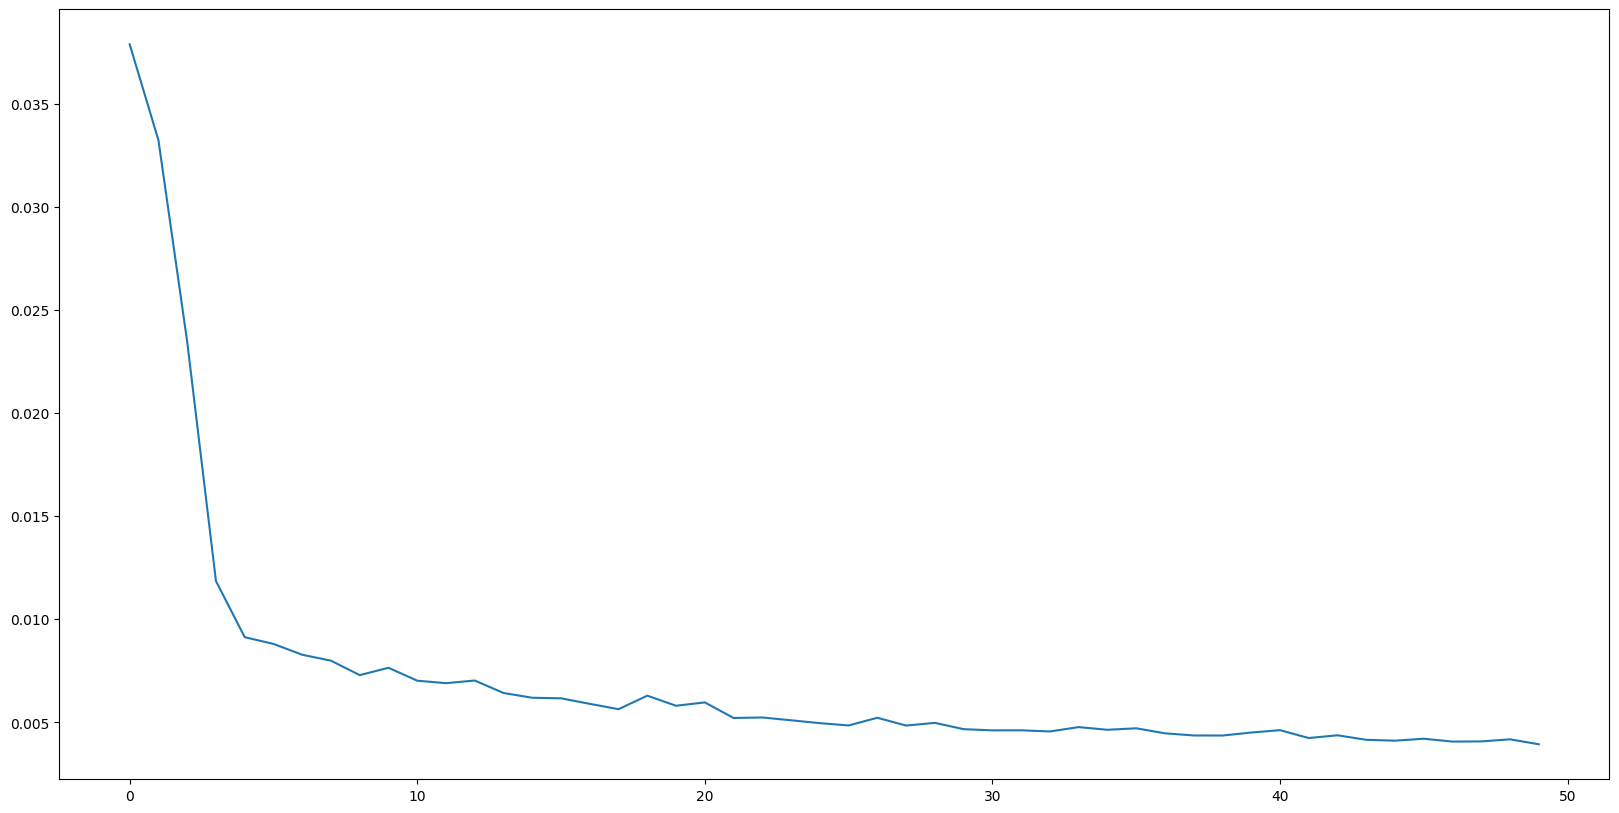

In [53]:
loss_graph = []
n = len(train_loader) #n : 학습데이터의 mini batch 개수

for epoch in range(num_epochs): # 에폭만큼 반복
  running_loss = 0  #running_loss : 누적 손실값

  for data in train_loader:
    seq, target = data #배치 데이터에서 시퀀스랑 정답 꺼내기
    out = model(seq) #시퀀스를 모델에 넣어 출력값 계산
    loss = criterion(out, target) #손실함수 계산

    optimizer.zero_grad() #gradient 초기화
    loss.backward() #backpropagation
    optimizer.step() #최적화 -> weight 업데이트
    running_loss += loss.item()

  loss_graph.append(running_loss/n) #loss_graph : epoch 당 평균 손실 기록
  if epoch % 10 ==0:
    print('[epoch : %d] loss: %.4f' %(epoch, running_loss/n))


plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()

In [54]:
concatdata = torch.utils.data.ConcatDataset([train, test]) #전체 데이터를 예측해보자
data_loader = torch.utils.data.DataLoader(dataset = concatdata, batch_size = 100) #데이터 불러오기

with torch.no_grad(): #예측할때 Gradient 계산 비활성화
  pred = []
  model.eval() #평가모드
  for data in data_loader:
    seq, target = data
    out = model(seq)
    pred += out.cpu().tolist() #pred에 예측값 계속 이어붙이기
    #GPU -> CPU -> list

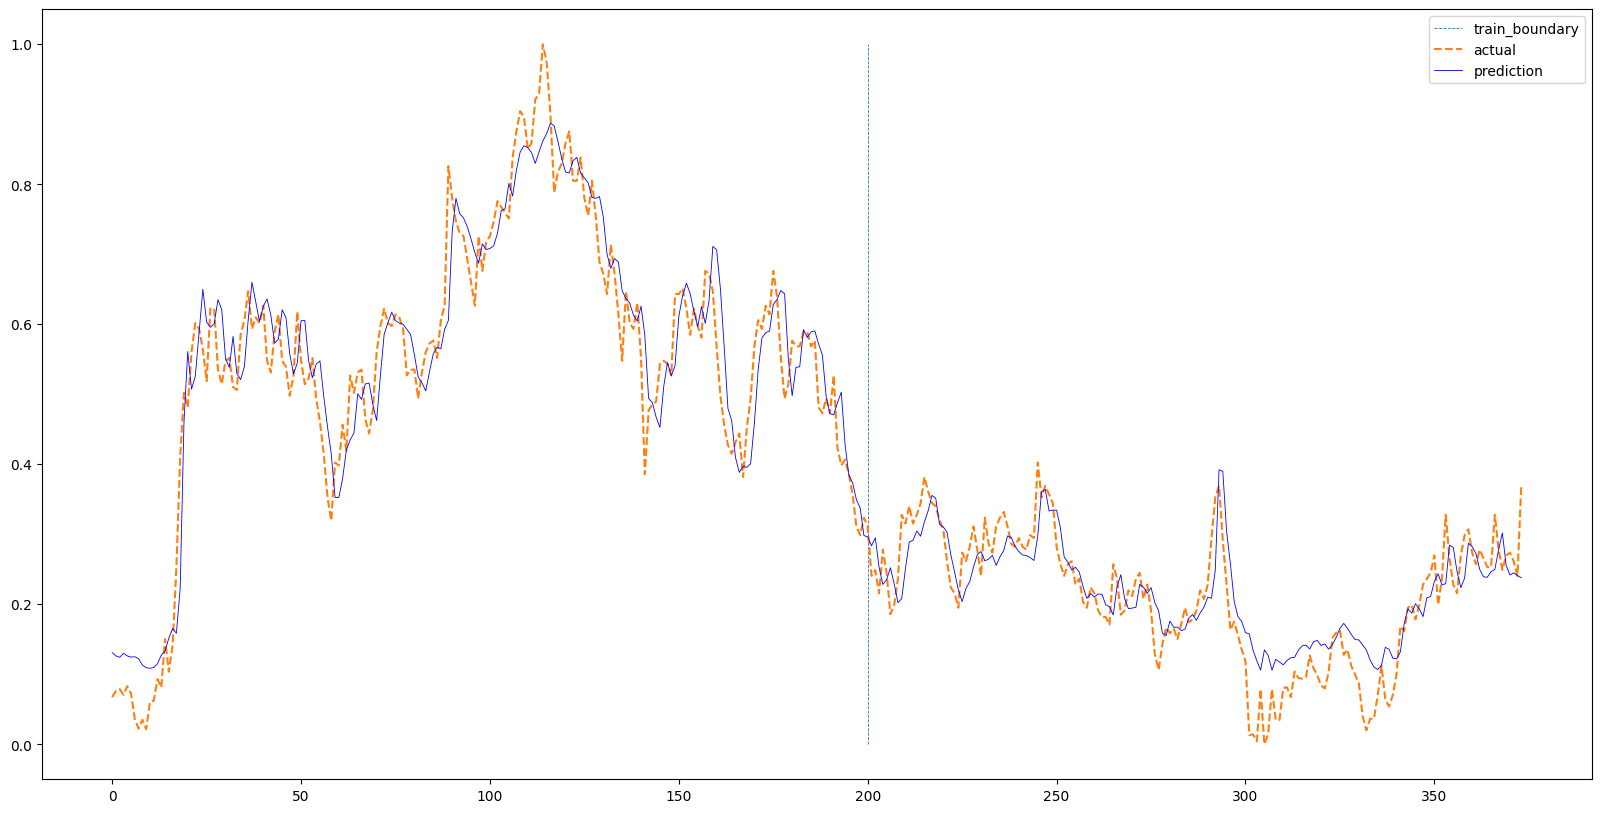

In [55]:
plt.figure(figsize = (20,10))
plt.plot(np.ones(100)*len(train), np.linspace(0,1,100), '--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred, 'b', linewidth = 0.6)
plt.legend(['train_boundary','actual','prediction'])
plt.show()

# LSTM

In [56]:
#하이퍼 파라미터 정의
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(LSTM, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    #내부적으로는 forget gate, input gate, output gate가 자동으로 작동. 입력형태는 RNN과 동일
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_size*sequence_length ,1)

  def forward(self, x):
    #이번엔 hidden state 뿐 아니라 cell state(장기기억용 셀 상태)까지 초기화 -> 0으로 설정
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    c0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    out, _ = self.lstm(x,(h0,c0)) #두개의 초기상태를 받음
    out = out.reshape(out.shape[0], -1) # 모든 hidden state를 이어붙임
    out = self.fc(out)
    return out

In [57]:

#아래는 RNN 부분과 같음
model = LSTM(input_size = input_size,
             hidden_size=hidden_size,
             sequence_length=sequence_length,
             num_layers = num_layers,
             device=device).to(device)

criterion = nn.MSELoss()
num_epochs =50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [58]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0

    for data in train_loader:

        seq, target = data # 배치 데이터
        out = model(seq)
        loss = criterion(out, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_graph.append(running_loss/n)
    if epoch % 10 == 0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))

[epoch: 0] loss: 0.1397
[epoch: 10] loss: 0.0081
[epoch: 20] loss: 0.0076
[epoch: 30] loss: 0.0072
[epoch: 40] loss: 0.0060


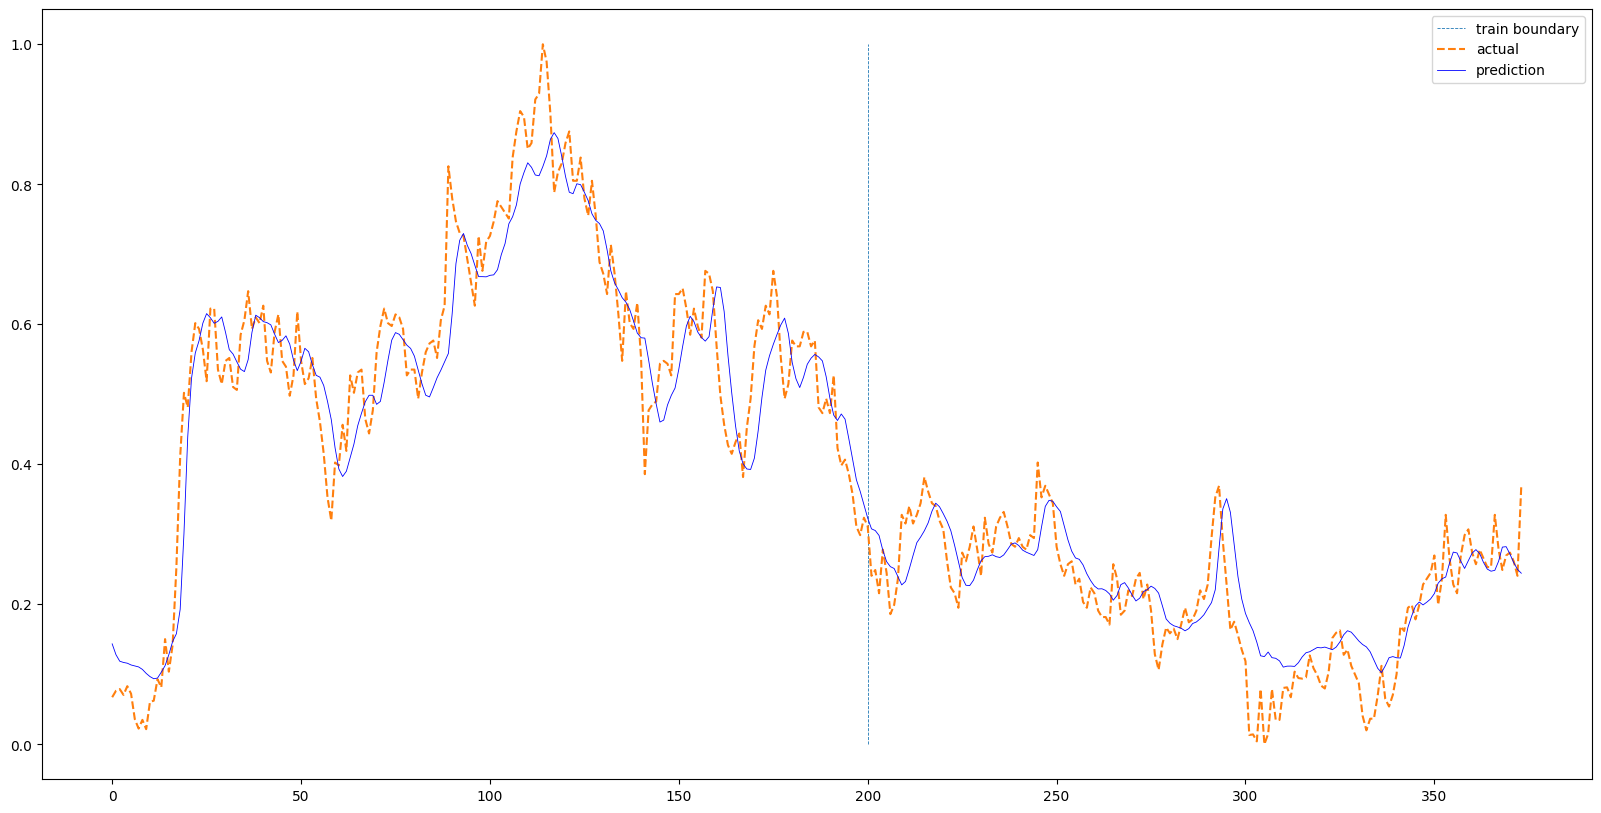

In [59]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset=concatdata, batch_size=100, shuffle=False)

with torch.no_grad():
    pred = []
    model.eval()
    for data in data_loader:
        seq, target = data
        out = model(seq)
        pred += out.cpu().tolist()

plt.figure(figsize=(20,10))
plt.plot(np.ones(100)*len(train),np.linspace(0,1,100),'--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred,'b', linewidth=0.6)
plt.legend(['train boundary','actual','prediction'])
plt.show()

LSTM이 초기 loss값은 높았으나 점점 RNN과 비슷하게 예측하게 됨. 둘다 시각화 결과 잘 따라가는 편이나 LSTM에서 진폭 차이가 test data에서 특히 더욱 존재함.